In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons
import PIL.Image as im
import matplotlib.pyplot as plt
import sklearn as sk
import os
import pydot
from keras.utils.vis_utils import plot_model

In [2]:
batch_size = 1024
patch_size = 4
transformer_layers = 6
hidden_size = 64
num_heads = 4
mlp_dim = 128

In [3]:
data = np.load("/kaggle/input/commonicmsexp/Dataset_Experiment.npy")
data.shape

(498000, 2049)

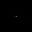

In [4]:
channel1 = data[0,0:1024]
channel2 = data[0,1024:2048]
channel1 = im.fromarray(np.reshape(channel1, (32,32)))
channel2 = im.fromarray(np.reshape(channel2,(32,32)))
channel1

In [5]:
def generate_patch_conv_orgPaper_f(patch_size, hidden_size, inputs):
  patches = tf.keras.layers.Conv2D(filters=hidden_size,
             kernel_size=patch_size,
             strides=patch_size,
             padding='valid')(inputs)
  seq_len = (inputs.shape[1] // patch_size) * (inputs.shape[2] // patch_size)
  x = tf.reshape(patches, [-1, seq_len, hidden_size])
  return x

In [6]:
class AddPositionEmbs(tf.keras.layers.Layer):
    def __init__(self, posemb_init=None, **kwargs):
        super().__init__(**kwargs)
        self.posemb_init = posemb_init
    
    def build(self, inputs_shape):
        pos_emb_shape = (1, inputs_shape[1], inputs_shape[2])
        self.pos_embedding = self.add_weight('pos_embedding', pos_emb_shape, initializer=self.posemb_init)

    def call(self, inputs, inputs_positions=None):
        pos_embedding = tf.cast(self.pos_embedding, inputs.dtype)
        return inputs + pos_embedding

pos_embed_layer = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02))  

In [7]:
def mlp_block_f(mlp_dim, inputs):
  x = tf.keras.layers.Dense(units=mlp_dim, activation=tf.nn.gelu)(inputs)
  x = tf.keras.layers.Dropout(rate=0.1)(x)
  x = tf.keras.layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
  x = tf.keras.layers.Dropout(rate=0.1)(x)
  return x

In [8]:
def Encoder1Dblock_f(num_heads, mlp_dim, inputs):
  x = tf.keras.layers.LayerNormalization(dtype=inputs.dtype)(inputs)
  x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) 

  x = tf.keras.layers.Add()([x, inputs]) 
  
  y = tf.keras.layers.LayerNormalization(dtype=x.dtype)(x)
  y = mlp_block_f(mlp_dim, y)
  y_1 = tf.keras.layers.Add()([y, x]) 
  return y_1

In [9]:
def Encoder_f(num_layers, mlp_dim, num_heads, inputs):
  x = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02))(inputs)
  x = tf.keras.layers.Dropout(rate=0.2)(x)
  for _ in range(num_layers):
    x = Encoder1Dblock_f(num_heads, mlp_dim, x)

  encoded = tf.keras.layers.LayerNormalization()(x)
  return encoded

In [10]:
inputs = tf.keras.Input(shape=(2048,))

x = inputs[:,0:1024]
x = tf.keras.layers.Reshape((32,32,1))(x)

y = inputs[:,1024:2048]
y = tf.keras.layers.Reshape((32,32,1))(y)

rescale_x = tf.keras.layers.Rescaling(scale=1./255)(x)
rescale_y = tf.keras.layers.Rescaling(scale=1./255)(y)
patches_x = generate_patch_conv_orgPaper_f(patch_size, hidden_size, rescale_x)
patches_y = generate_patch_conv_orgPaper_f(patch_size, hidden_size, rescale_y)
encoder_out_x = Encoder_f(transformer_layers, mlp_dim, num_heads, patches_x)
encoder_out_y = Encoder_f(transformer_layers, mlp_dim, num_heads, patches_y)
im_representation_x = tf.reduce_mean(encoder_out_x, axis=1)
im_representation_y = tf.reduce_mean(encoder_out_y, axis=1)
im_representation = tf.keras.layers.concatenate([im_representation_x,im_representation_y],axis = -1)

output = tf.keras.layers.Dense(units= 1 ,name='head',activation = "sigmoid")(im_representation)


2022-04-07 11:01:08.829173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 11:01:08.925410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 11:01:08.926246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 11:01:08.927377: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

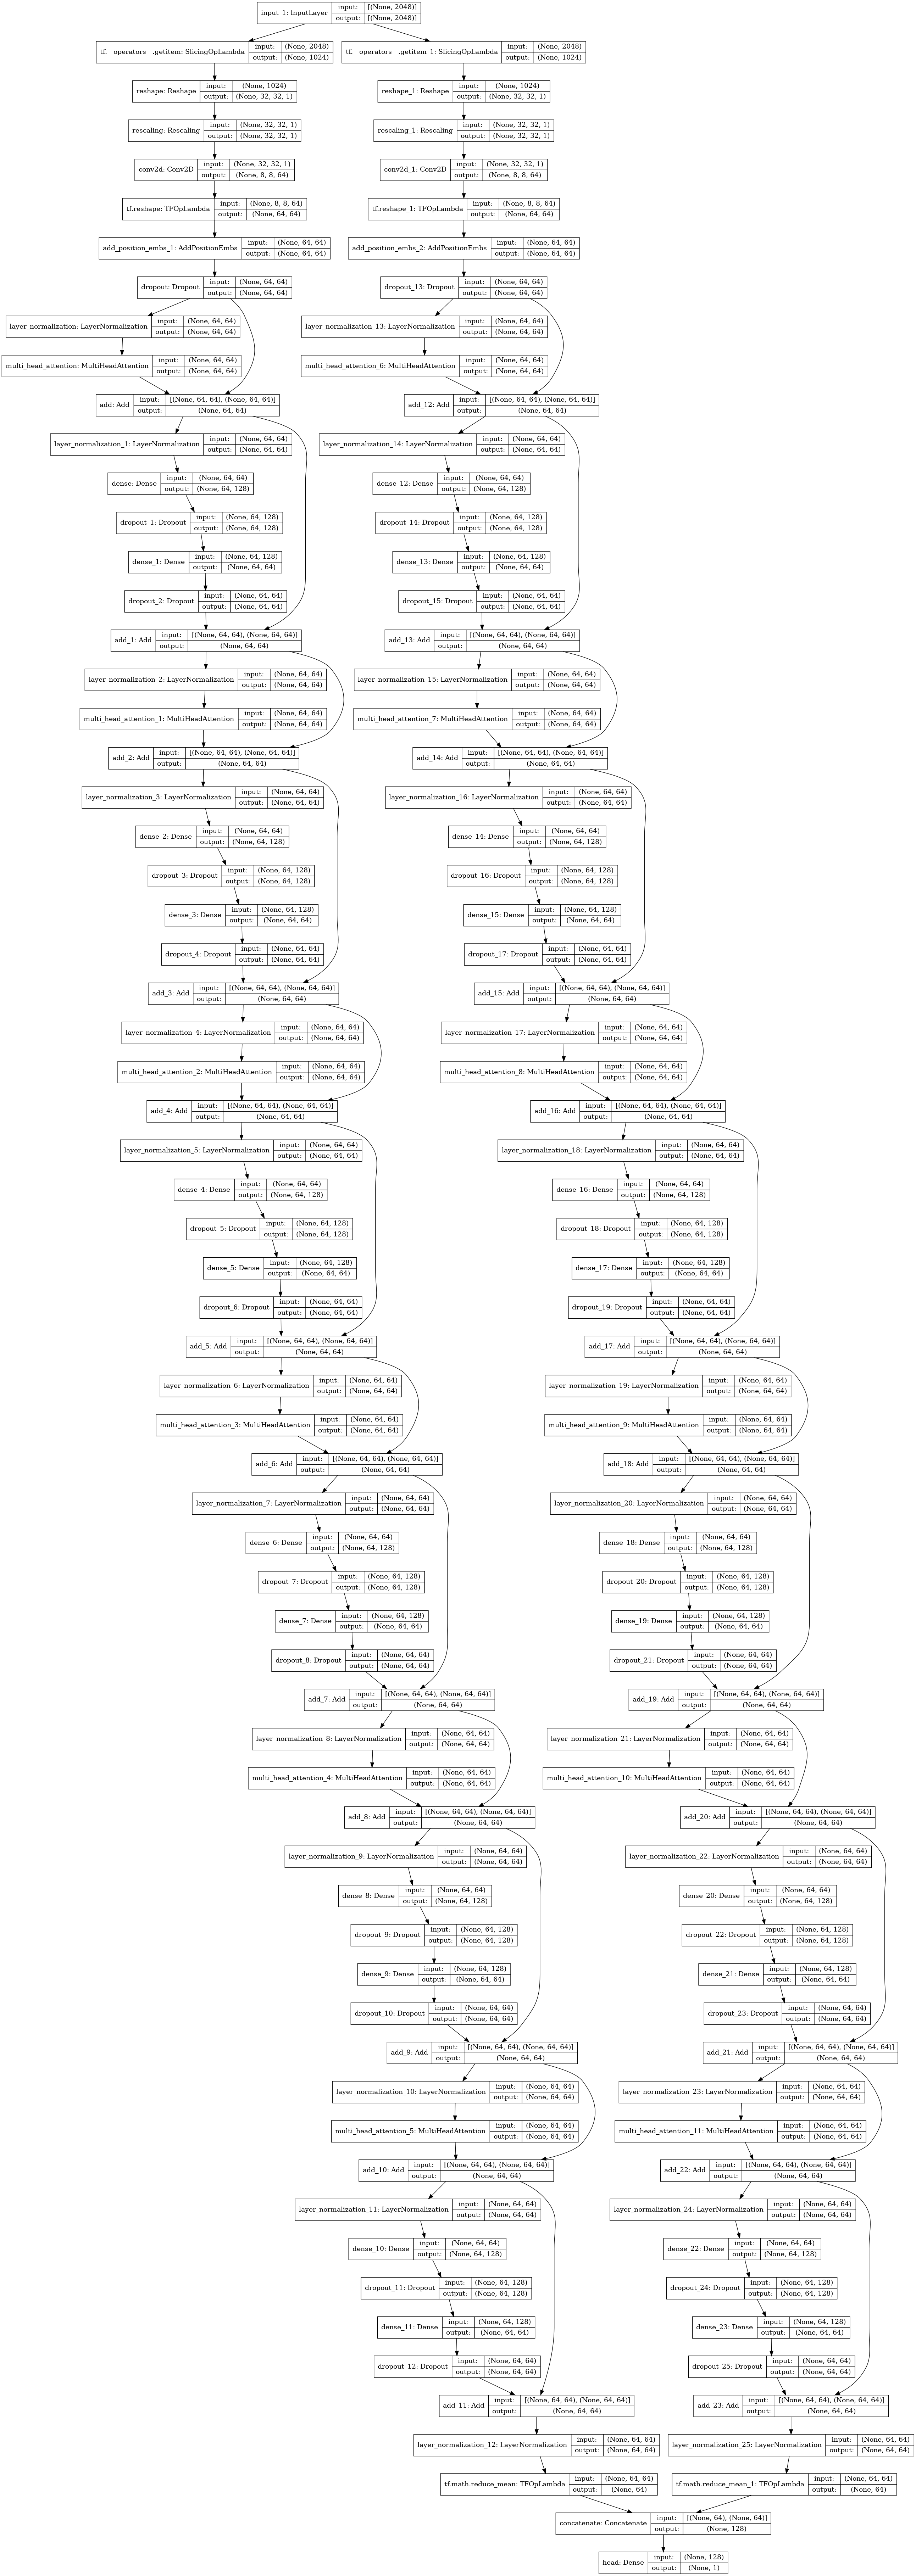

In [11]:
model = tf.keras.Model(inputs, output)
plot_model(model, "Vit.png", show_shapes=True)

In [12]:
from tensorflow_addons.optimizers import CyclicalLearningRate
cyclical_learning_rate = CyclicalLearningRate(
 initial_learning_rate=1e-7,
 maximal_learning_rate=3e-3,
 step_size=1557*6,
 scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
 scale_mode='cycle')

In [13]:
model.compile(
optimizer=tf.keras.optimizers.Adam(
            learning_rate = cyclical_learning_rate),
loss= tf.keras.losses.BinaryCrossentropy(),
metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"),
                tf.keras.metrics.AUC(name = "auc")])


In [14]:
ck = tf.keras.callbacks.ModelCheckpoint(
    "./cp.ckpt",
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    save_freq=1557
)

In [15]:
history = model.fit(
    data[:,:2048],
    data[:,2048],
    batch_size = 256,
    validation_split = 0.2,
    verbose = 2,
    epochs=150,
    callbacks = [ck]
    
)

2022-04-07 11:01:16.244581: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 815923200 exceeds 10% of free system memory.
2022-04-07 11:01:17.091778: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 815923200 exceeds 10% of free system memory.
2022-04-07 11:01:17.705866: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-04-07 11:01:28.975620: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005



Epoch 00001: saving model to ./cp.ckpt
1557/1557 - 254s - loss: 0.6760 - accuracy: 0.5617 - auc: 0.5964 - val_loss: 0.6428 - val_accuracy: 0.6493 - val_auc: 0.7099
Epoch 2/150

Epoch 00002: saving model to ./cp.ckpt
1557/1557 - 236s - loss: 0.6192 - accuracy: 0.6651 - auc: 0.7157 - val_loss: 0.6434 - val_accuracy: 0.6529 - val_auc: 0.7207
Epoch 3/150

Epoch 00003: saving model to ./cp.ckpt
1557/1557 - 235s - loss: 0.6105 - accuracy: 0.6746 - auc: 0.7275 - val_loss: 0.6072 - val_accuracy: 0.6802 - val_auc: 0.7432
Epoch 4/150

Epoch 00004: saving model to ./cp.ckpt
1557/1557 - 236s - loss: 0.6083 - accuracy: 0.6773 - auc: 0.7304 - val_loss: 0.5942 - val_accuracy: 0.6899 - val_auc: 0.7480
Epoch 5/150

Epoch 00005: saving model to ./cp.ckpt
1557/1557 - 236s - loss: 0.6058 - accuracy: 0.6799 - auc: 0.7336 - val_loss: 0.5997 - val_accuracy: 0.6844 - val_auc: 0.7415
Epoch 6/150

Epoch 00006: saving model to ./cp.ckpt
1557/1557 - 236s - loss: 0.6058 - accuracy: 0.6797 - auc: 0.7336 - val_loss

In [16]:
import pandas as pd
pd.DataFrame.from_dict(history.history).to_csv('history.csv',index=False)


In [8]:
history  = pd.read_csv("history.csv")

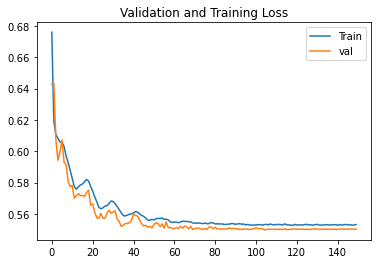

In [9]:
plt.plot( np.array(range(0,150)), np.array(history["loss"]), label = "Train" )
plt.plot( np.array(range(0,150)), np.array(history["val_loss"]) ,label = "val")
plt.title("Validation and Training Loss")
plt.legend()
plt.show()

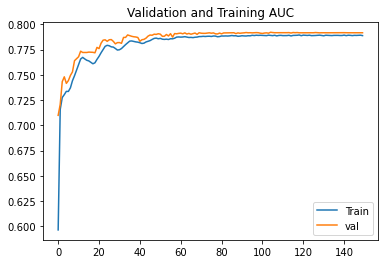

In [10]:
plt.plot( np.array(range(0,150)), np.array(history["auc"]), label = "Train" )
plt.plot( np.array(range(0,150)), np.array(history["val_auc"]) ,label = "val")
plt.title("Validation and Training AUC")
plt.legend()
plt.show()

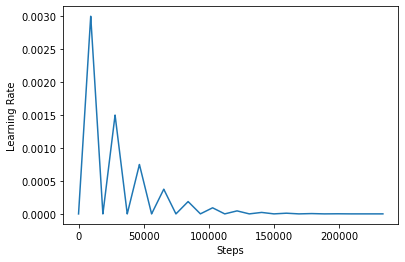

In [13]:
step = np.arange(0, 150 * 1557)
lr = cyclical_learning_rate(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()